<a href="https://colab.research.google.com/github/tk1475/ATML-PA0/blob/master/notebooks/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.1: Baseline GAN on MNIST

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("out_gan", exist_ok=True)

### Models

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x.view(-1, 784)).squeeze(1)


Weights init

In [3]:
def weights_init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
loader = DataLoader(train_ds, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.01MB/s]


### Init models + optim


In [5]:
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init_normal)
D.apply(weights_init_normal)

optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Fixed noise for monitoring
fixed_noise = torch.randn(25, z_dim, device=device)


## Training loop : alongside progress tracking and outputting data

In [6]:
epochs = 20
G_losses, D_losses = [], []

for epoch in range(epochs):
    for real_imgs, _ in loader:
        bs = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # ----------------- Train D -----------------
        optD.zero_grad()
        real_labels = torch.ones(bs, device=device)
        fake_labels = torch.zeros(bs, device=device)

        out_real = D(real_imgs)
        loss_real = criterion(out_real, real_labels)

        noise = torch.randn(bs, z_dim, device=device)
        fake_imgs = G(noise).detach()
        out_fake = D(fake_imgs)
        loss_fake = criterion(out_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()

        # ----------------- Train G -----------------
        optG.zero_grad()
        noise = torch.randn(bs, z_dim, device=device)
        fake_imgs = G(noise)
        out_fake = D(fake_imgs)
        loss_G = criterion(out_fake, real_labels)  # non-saturating trick
        loss_G.backward()
        optG.step()

        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

    # Save samples each epoch
    with torch.no_grad():
        samples = G(fixed_noise).cpu()
    utils.save_image(samples, f"out_gan/epoch_{epoch+1:03d}.png", nrow=5, normalize=True, value_range=(-1,1))

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")



Epoch [1/20]  Loss D: 1.3914, Loss G: 1.1854
Epoch [2/20]  Loss D: 1.3468, Loss G: 1.0576
Epoch [3/20]  Loss D: 1.2414, Loss G: 0.8374
Epoch [4/20]  Loss D: 1.4047, Loss G: 0.6179
Epoch [5/20]  Loss D: 1.4096, Loss G: 0.6878
Epoch [6/20]  Loss D: 1.3936, Loss G: 0.7626
Epoch [7/20]  Loss D: 1.3721, Loss G: 0.7763
Epoch [8/20]  Loss D: 1.2986, Loss G: 0.8043
Epoch [9/20]  Loss D: 1.3606, Loss G: 1.0749
Epoch [10/20]  Loss D: 1.3343, Loss G: 0.7902
Epoch [11/20]  Loss D: 1.2832, Loss G: 0.8116
Epoch [12/20]  Loss D: 1.3777, Loss G: 0.8109
Epoch [13/20]  Loss D: 1.3129, Loss G: 0.8291
Epoch [14/20]  Loss D: 1.3835, Loss G: 0.8401
Epoch [15/20]  Loss D: 1.3051, Loss G: 0.6909
Epoch [16/20]  Loss D: 1.3718, Loss G: 0.8340
Epoch [17/20]  Loss D: 1.2598, Loss G: 0.7587
Epoch [18/20]  Loss D: 1.2222, Loss G: 0.7784
Epoch [19/20]  Loss D: 1.3512, Loss G: 0.9228
Epoch [20/20]  Loss D: 1.2242, Loss G: 0.8158


### Save loss curves


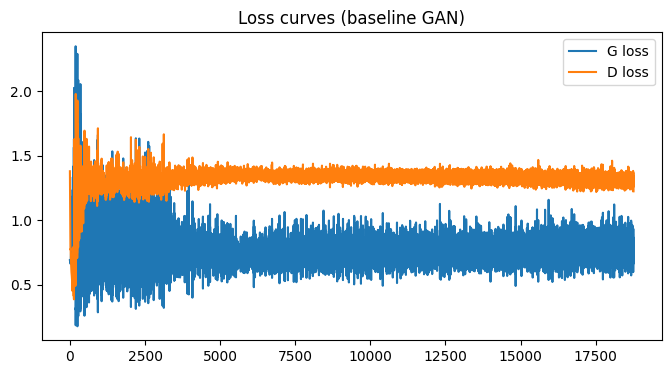

In [7]:

plt.figure(figsize=(8,4))
plt.plot(G_losses, label="G loss")
plt.plot(D_losses, label="D loss")
plt.legend()
plt.title("Loss curves (baseline GAN)")
plt.savefig("out_gan/losses.png", bbox_inches="tight")
plt.show()

# 3.2: Training Issues

## Gradient Vanishing

In [14]:
import os, random, numpy as np, torch, math
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
import torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42); np.random.seed(42); random.seed(42)

def make_outdir(name):
    out = f"out_gan/{name}"
    os.makedirs(out, exist_ok=True)
    return out

def save_grid(tensor_batch, fname, nrow=5):
    # expects tensor in range [-1,1]
    img = utils.make_grid(tensor_batch, nrow=nrow, normalize=True, value_range=(-1,1))
    utils.save_image(img, fname)

### Data Loader MNIST

In [16]:
def get_mnist_loader(batch_size=64, use_subset=False, subset_size=2000):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
    if use_subset:
        ds = Subset(ds, list(range(min(subset_size, len(ds)))))
    return DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1)).squeeze(1)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None: nn.init.constant_(m.bias, 0.0)
    if isinstance(m, (nn.BatchNorm1d,)):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0.0)

In [5]:
def train_vanish_experiment(cfg, outdir):
    """
    cfg keys:
      epochs, batch_size, z_dim,
      lr_d, lr_g, betas,
      d_steps, use_non_saturating (bool),
      label_smoothing (float or None),
      use_subset (bool), subset_size (int)
    """
    loader = get_mnist_loader(batch_size=cfg.get("batch_size",64),
                              use_subset=cfg.get("use_subset", True),
                              subset_size=cfg.get("subset_size", 2000))
    G = Generator(z_dim=cfg.get("z_dim",100)).to(device)
    D = Discriminator().to(device)
    G.apply(weights_init); D.apply(weights_init)

    optG = optim.Adam(G.parameters(), lr=cfg.get("lr_g",2e-4), betas=cfg.get("betas",(0.5,0.999)))
    optD = optim.Adam(D.parameters(), lr=cfg.get("lr_d",2e-4), betas=cfg.get("betas",(0.5,0.999)))
    criterion = nn.BCELoss()

    fixed_noise = torch.randn(25, cfg.get("z_dim",100), device=device)
    losses = {"D":[], "G":[], "D_real":[], "D_fake":[], "D_real_avg":[], "D_fake_avg":[]}

    for epoch in range(cfg.get("epochs",8)):
        pbar = tqdm(loader, desc=f"{outdir} Epoch {epoch+1}/{cfg.get('epochs',8)}", leave=False)
        for real, _ in pbar:
            real = real.to(device)
            bs = real.size(0)

            # ---- Train D (d_steps times) ----
            for _ in range(cfg.get("d_steps",1)):
                D.zero_grad()
                # real
                tgt_real = torch.full((bs,), 1.0, device=device)
                if cfg.get("label_smoothing", None) is not None:
                    tgt_real = tgt_real * float(cfg["label_smoothing"])
                out_real = D(real)
                loss_real = criterion(out_real, tgt_real)

                # fake
                z = torch.randn(bs, cfg.get("z_dim",100), device=device)
                fake = G(z).detach()
                out_fake = D(fake)
                tgt_fake = torch.zeros(bs, device=device)
                loss_fake = criterion(out_fake, tgt_fake)

                lossD = loss_real + loss_fake
                lossD.backward()
                optD.step()

            # ---- Train G ----
            G.zero_grad()
            z = torch.randn(bs, cfg.get("z_dim",100), device=device)
            fake2 = G(z)
            out_fake_forG = D(fake2)
            if cfg.get("use_non_saturating", True):
                # non-saturating trick: target labels = 1
                tgt_forG = torch.ones(bs, device=device)
                lossG = criterion(out_fake_forG, tgt_forG)
            else:
                # original minimax: minimize log(1-D(G(z))) -> use stable mean log(1-x)
                lossG = - torch.log(1 - out_fake_forG + 1e-8).mean()

            lossG.backward()
            optG.step()

            # logging
            with torch.no_grad():
                losses["D"].append(lossD.item())
                losses["G"].append(lossG.item())
                losses["D_real"].append(loss_real.item())
                losses["D_fake"].append(loss_fake.item())
                losses["D_real_avg"].append(out_real.mean().item())
                losses["D_fake_avg"].append(out_fake.mean().item())

        # save epoch samples
        G.eval()
        with torch.no_grad():
            samples = G(fixed_noise).cpu()
            save_grid(samples, f"{outdir}/epoch_{epoch+1:03d}.png", nrow=5)
        G.train()

        print(f"{outdir} epoch {epoch+1}: last D={lossD.item():.4f}, G={lossG.item():.4f}, D_real_avg={losses['D_real_avg'][-1]:.3f}, D_fake_avg={losses['D_fake_avg'][-1]:.3f}")

    # save loss arrays + plot
    np.save(f"{outdir}/losses.npy", losses)
    # smoothed plot
    def smooth(x,w=50):
        if len(x) < w: return x
        return np.convolve(x, np.ones(w)/w, mode='valid')
    plt.figure(figsize=(8,4))
    plt.plot(smooth(losses["D"]), label="D (smoothed)")
    plt.plot(smooth(losses["G"]), label="G (smoothed)")
    plt.legend(); plt.title(outdir + " smoothed losses")
    plt.savefig(f"{outdir}/losses.png", bbox_inches="tight"); plt.close()

    return {"G":G, "D":D, "losses":losses, "outdir": outdir}

In [6]:
vanish_cfg = {
    "epochs": 8, "batch_size": 64, "z_dim":100,
    # make D too strong:
    "lr_d": 1e-3, "lr_g": 2e-4, "betas": (0.5,0.999),
    "d_steps": 5, "use_non_saturating": False, "label_smoothing": None,
    "use_subset": True, "subset_size": 2000
}

vanish_mitigate_cfg = {
    "epochs": 10, "batch_size": 64, "z_dim":100,
    "lr_d": 2e-4, "lr_g": 2e-4, "betas": (0.5,0.999),
    "d_steps": 1, "use_non_saturating": True, "label_smoothing": 0.9,
    "use_subset": True, "subset_size": 2000
}

# -------- run experiments --------
out_vanish = make_outdir("vanish")
out_vanish_m = make_outdir("vanish_mitigate")

print("Running vanishing-grads inducing run (this should show D saturating)...")
res_v = train_vanish_experiment(vanish_cfg, out_vanish)

print("\nRunning mitigation run (label smoothing + non-sat G + balanced D/G)...")
res_vm = train_vanish_experiment(vanish_mitigate_cfg, out_vanish_m)

Running vanishing-grads inducing run (this should show D saturating)...


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


out_gan/vanish Epoch 1/8:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish epoch 1: last D=0.0003, G=0.0002, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 2/8:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish epoch 2: last D=0.0001, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 3/8:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish epoch 3: last D=0.0000, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 4/8:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish epoch 4: last D=0.0000, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 5/8:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish epoch 5: last D=0.0000, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 6/8:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish epoch 6: last D=0.0000, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 7/8:   0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()  
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():
 ^^ ^^  ^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^  ^^ ^^ ^^ ^  ^^ ^  ^
  File "/us

out_gan/vanish epoch 7: last D=0.0000, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000


out_gan/vanish Epoch 8/8:   0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
     ^ ^ ^ ^ ^ ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^ ^ 
  File "/usr/lib/pyth

out_gan/vanish epoch 8: last D=0.0000, G=0.0000, D_real_avg=1.000, D_fake_avg=0.000

Running mitigation run (label smoothing + non-sat G + balanced D/G)...


out_gan/vanish_mitigate Epoch 1/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 1: last D=0.9549, G=0.7781, D_real_avg=0.875, D_fake_avg=0.465


out_gan/vanish_mitigate Epoch 2/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 2: last D=0.7913, G=1.0109, D_real_avg=0.879, D_fake_avg=0.370


out_gan/vanish_mitigate Epoch 3/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 3: last D=0.8000, G=1.1206, D_real_avg=0.667, D_fake_avg=0.270


out_gan/vanish_mitigate Epoch 4/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 4: last D=0.6818, G=1.5203, D_real_avg=0.874, D_fake_avg=0.293


out_gan/vanish_mitigate Epoch 5/10:   0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>   
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^ ^^  ^ ^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ ^ ^ ^  
   File "/usr/li

out_gan/vanish_mitigate epoch 5: last D=0.7742, G=1.3127, D_real_avg=0.752, D_fake_avg=0.308


out_gan/vanish_mitigate Epoch 6/10:   0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78d9cc0c1bc0>
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
if w.is_alive():   
       ^^ ^ ^  ^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

out_gan/vanish_mitigate epoch 6: last D=0.8994, G=1.2997, D_real_avg=0.721, D_fake_avg=0.372


out_gan/vanish_mitigate Epoch 7/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 7: last D=0.8926, G=1.3506, D_real_avg=0.757, D_fake_avg=0.376


out_gan/vanish_mitigate Epoch 8/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 8: last D=1.0538, G=0.7556, D_real_avg=0.551, D_fake_avg=0.343


out_gan/vanish_mitigate Epoch 9/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 9: last D=1.0112, G=0.5894, D_real_avg=0.550, D_fake_avg=0.311


out_gan/vanish_mitigate Epoch 10/10:   0%|          | 0/32 [00:00<?, ?it/s]

out_gan/vanish_mitigate epoch 10: last D=1.0706, G=0.7326, D_real_avg=0.495, D_fake_avg=0.295


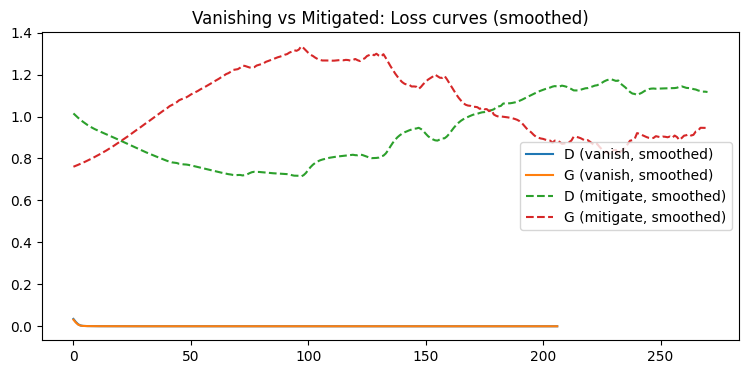

Saved comparison plot: out_gan/vanish_vs_mitigate_losses.png
Saved epoch samples into the respective output folders.


In [7]:
loss_v = res_v["losses"]
loss_vm = res_vm["losses"]

def smooth_arr(x,w=50):
    if len(x) < w: return np.array(x)
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(9,4))
plt.plot(smooth_arr(loss_v["D"]), label="D (vanish, smoothed)")
plt.plot(smooth_arr(loss_v["G"]), label="G (vanish, smoothed)")
plt.plot(smooth_arr(loss_vm["D"]), '--', label="D (mitigate, smoothed)")
plt.plot(smooth_arr(loss_vm["G"]), '--', label="G (mitigate, smoothed)")
plt.legend()
plt.title("Vanishing vs Mitigated: Loss curves (smoothed)")
plt.savefig("out_gan/vanish_vs_mitigate_losses.png", bbox_inches="tight")
plt.show()

print("Saved comparison plot: out_gan/vanish_vs_mitigate_losses.png")
print("Saved epoch samples into the respective output folders.")

## Mode Collapse

In [8]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [24]:
z_dim = 100
batch_size = 64
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

In [18]:

def show_generated(G, epoch, z_dim, device, n_images=16):
    G.eval()
    z = torch.randn(n_images, z_dim).to(device)
    samples = G(z).detach().cpu()
    samples = (samples + 1) / 2  # scale to [0,1]

    fig, axes = plt.subplots(4, 4, figsize=(4,4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i][0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()
    G.train()

In [21]:
def show_generated(G, epoch, n_images=16):
    G.eval()
    z = torch.randn(n_images, z_dim).to(device)
    samples = G(z).detach().cpu()
    samples = (samples+1)/2
    fig, axes = plt.subplots(4,4, figsize=(4,4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i][0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()
    G.train()

In [23]:
def train_gan(G, D, loader, mode_collapse=False, mitigation=False):
    G.to(device)
    D.to(device)
    criterion = nn.BCELoss()

    # Hyperparams depending on scenario
    if mode_collapse:
        lr_G, lr_D = 0.01, 0.0001  # strong G, weak D
        D_steps, G_steps = 1, 5
    elif mitigation:
        lr_G, lr_D = 0.0005, 0.005  # stronger D
        D_steps, G_steps = 2, 1
    else:
        lr_G, lr_D = 0.0005, 0.0005
        D_steps, G_steps = 1, 1

    G_opt = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5,0.999))
    D_opt = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5,0.999))

    for epoch in range(1, num_epochs+1):
        for real_imgs, _ in loader:
            real_imgs = real_imgs.to(device)
            batch_size_curr = real_imgs.size(0)

            # Train Discriminator
            for _ in range(D_steps):
                D_opt.zero_grad()
                z = torch.randn(batch_size_curr, z_dim).to(device)
                fake_imgs = G(z).detach()
                D_loss = criterion(D(real_imgs), torch.ones(batch_size_curr).to(device)) + \
                         criterion(D(fake_imgs), torch.zeros(batch_size_curr).to(device))
                D_loss.backward()
                D_opt.step()

            # Train Generator
            for _ in range(G_steps):
                G_opt.zero_grad()
                z = torch.randn(batch_size_curr, z_dim).to(device)
                fake_imgs = G(z)
                G_loss = criterion(D(fake_imgs), torch.ones(batch_size_curr).to(device))
                G_loss.backward()
                G_opt.step()

        if epoch % 5 == 0:
            show_generated(G, epoch)

## Mode Collapse case

=== Mode Collapse Scenario ===


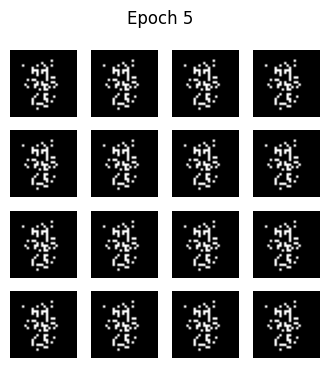

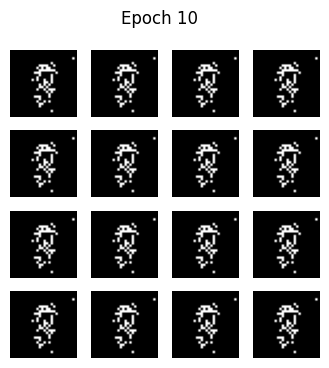

In [25]:
print("=== Mode Collapse Scenario ===")
G = Generator()
D = Discriminator()
train_gan(G, D, train_loader, mode_collapse=True)

## Mitigation

=== Mitigation Scenario ===


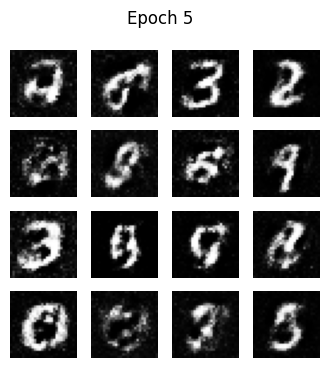

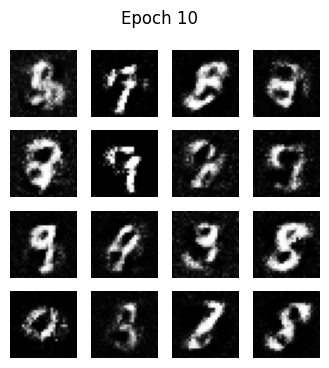

In [26]:
print("=== Mitigation Scenario ===")
G = Generator()
D = Discriminator()
train_gan(G, D, train_loader, mitigation=True)

## Discriminator Overfitting

In [44]:
z_dim = 100
batch_size = 64
lr_g = 2e-4
lr_d = 2e-4
num_epochs = 100
dropout_rate = 0.4  # for mitigation
limited_dataset_size = 1000  # simulate overfitting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
subset_indices = list(range(limited_dataset_size))
train_dataset = Subset(full_dataset, subset_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [37]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1)).squeeze(1)


In [38]:
def train_gan(generator, discriminator, train_loader, z_dim, lr_g, lr_d, num_epochs, device):
    G = generator.to(device)
    D = discriminator.to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for real_imgs, _ in train_loader:
            real_imgs = real_imgs.to(device)
            batch_size_curr = real_imgs.size(0)

            # Labels
            real_labels = torch.ones(batch_size_curr, device=device)
            fake_labels = torch.zeros(batch_size_curr, device=device)

            # -----------------
            # Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            outputs_real = D(real_imgs)
            loss_real = criterion(outputs_real, real_labels)

            z = torch.randn(batch_size_curr, z_dim, device=device)
            fake_imgs = G(z)
            outputs_fake = D(fake_imgs.detach())
            loss_fake = criterion(outputs_fake, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad()
            outputs_fake_for_G = D(fake_imgs)
            loss_G = criterion(outputs_fake_for_G, real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    return G, D


In [45]:
print("Training with overfitting discriminator (no dropout)")
G_overfit, D_overfit = train_gan(Generator(), Discriminator(dropout=0.0), train_loader, z_dim, lr_g, lr_d, num_epochs, device)

Training with overfitting discriminator (no dropout)
Epoch [1/100] | D Loss: 0.6944 | G Loss: 0.7396
Epoch [2/100] | D Loss: 0.5666 | G Loss: 0.9034
Epoch [3/100] | D Loss: 0.4423 | G Loss: 1.1596
Epoch [4/100] | D Loss: 0.3606 | G Loss: 1.3724
Epoch [5/100] | D Loss: 0.3226 | G Loss: 1.4882
Epoch [6/100] | D Loss: 0.2383 | G Loss: 1.7625
Epoch [7/100] | D Loss: 0.1846 | G Loss: 2.0249
Epoch [8/100] | D Loss: 0.3143 | G Loss: 1.6614
Epoch [9/100] | D Loss: 0.2700 | G Loss: 2.0645
Epoch [10/100] | D Loss: 0.2345 | G Loss: 2.5127
Epoch [11/100] | D Loss: 0.2822 | G Loss: 2.8908
Epoch [12/100] | D Loss: 0.3484 | G Loss: 1.9651
Epoch [13/100] | D Loss: 0.2796 | G Loss: 2.5330
Epoch [14/100] | D Loss: 0.3139 | G Loss: 2.1282
Epoch [15/100] | D Loss: 0.4903 | G Loss: 0.9462
Epoch [16/100] | D Loss: 0.4617 | G Loss: 1.4417
Epoch [17/100] | D Loss: 0.8149 | G Loss: 0.8856
Epoch [18/100] | D Loss: 1.2861 | G Loss: 0.1924
Epoch [19/100] | D Loss: 0.6217 | G Loss: 1.4576
Epoch [20/100] | D Loss: 

In [46]:
print("Training with regularized discriminator (Dropout)")
G_mitigated, D_mitigated = train_gan(Generator(), Discriminator(dropout=dropout_rate), train_loader, z_dim, lr_g, lr_d, num_epochs, device)


Training with regularized discriminator (Dropout)
Epoch [1/100] | D Loss: 0.7332 | G Loss: 0.7058
Epoch [2/100] | D Loss: 0.6049 | G Loss: 0.8440
Epoch [3/100] | D Loss: 0.4693 | G Loss: 1.0624
Epoch [4/100] | D Loss: 0.3652 | G Loss: 1.3151
Epoch [5/100] | D Loss: 0.3220 | G Loss: 1.5019
Epoch [6/100] | D Loss: 0.2967 | G Loss: 1.6264
Epoch [7/100] | D Loss: 0.2584 | G Loss: 1.7701
Epoch [8/100] | D Loss: 0.2083 | G Loss: 2.1456
Epoch [9/100] | D Loss: 0.2357 | G Loss: 2.1705
Epoch [10/100] | D Loss: 0.2808 | G Loss: 2.1941
Epoch [11/100] | D Loss: 0.2614 | G Loss: 2.0996
Epoch [12/100] | D Loss: 0.1905 | G Loss: 2.5823
Epoch [13/100] | D Loss: 0.2704 | G Loss: 2.0868
Epoch [14/100] | D Loss: 0.4528 | G Loss: 2.6018
Epoch [15/100] | D Loss: 0.2641 | G Loss: 2.4137
Epoch [16/100] | D Loss: 0.6785 | G Loss: 1.1781
Epoch [17/100] | D Loss: 0.3661 | G Loss: 2.5906
Epoch [18/100] | D Loss: 0.9817 | G Loss: 1.5029
Epoch [19/100] | D Loss: 0.3183 | G Loss: 3.6681
Epoch [20/100] | D Loss: 0.3

In [47]:
import torchvision.utils as vutils
import os
os.makedirs("overfitting_experiment", exist_ok=True)

def save_samples(generator, name):
    generator.eval()
    z = torch.randn(64, z_dim, device=device)
    samples = generator(z)
    samples = (samples + 1) / 2  # rescale to [0,1]
    vutils.save_image(samples, f"overfitting_experiment/{name}.png", nrow=8)
    generator.train()

save_samples(G_overfit, "overfit.png")
save_samples(G_mitigated, "mitigated.png")